# Note
To fully run this notebook you are required to hold some data files in appropriate directories:
1) Trained GMM model object (pickle file)<br>
2) Video files to test on<br>
3) Images of authorized objects for preprocessing<br>
<br>
* To acheive the presented results, we trained offline our model on a larger set of videos, in this notebook we presented only the prediction part of some sample videos and not the training part.
* We would send the needed files for training for your request

# Init 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from os import path, listdir
from IPython.display import Video
import seaborn as sns
import pickle

from utils import *
from change_detection import *
from object_classification import *
from gmm import *

warnings.filterwarnings('ignore') 

# Single Video Example 
Detailed breakdown of the entire process on a single video

## Load Video

In [2]:
video_path = path.join('data', 'videos', 'approved.mp4')
colored_vid = load_video(video_path=video_path, gray_scale=False)
Video(video_path, height=400, width=600)

## Preprocessing
Encoding useful information from images of the authorized objects for later classification

In [3]:
# Initialize a list that will be filled with all the approved objects information
approved_objects_info = []

### Histograms Calculation

#### Load images

In [4]:
images_path = path.join('data', 'object_outline')
image_list = load_images(images_path)

#### Calculating the outline histograms

In [5]:
# Setting a 15X15 window size. A histogram will be calculated for each window in the image.
window_size = 15
histograms_mean_dict = generate_histograms_mean_dict(image_list, window_size)

#### Clustering the histograms mean and calculating the mean for each cluster

In [6]:
# Cluster the images histograms mean into 2 main bins.
bins = 2
allowed_histogram_means = calculate_allowed_histograms_means(histograms_mean_dict, bins)

### Object Size calculation

#### Creating a grid of the input image

In [7]:
# Taking the first image based on the knowledge all images sizes are the same
images_path = path.join('data', 'preprocessing_images')
image_to_grid = load_images(images_path)[0]

In [8]:
# Grid the image with boxes of 5X5
grid_size = 5
image_x_grid = np.arange(0, image_to_grid.shape[1], grid_size)
image_y_grid = np.arange(0, image_to_grid.shape[0], grid_size)

In [9]:
# Object_location describes the location as follows- [x, y, dx, dy].
# x,y- top left corner of the rectangle, dx,dy- length of the rectangle sides.
object_location = [600, 400, 300, 150] 
object_size_info = get_grids(image_x_grid, image_y_grid, object_location)

In [10]:
# Add the object information to 'approved_objects_info' database.
approved_objects_info.append({"RED": allowed_histogram_means["RED"],
                             "GREEN": allowed_histogram_means["GREEN"],
                             "BLUE": allowed_histogram_means["BLUE"],
                             "location": [object_size_info]})

## Change Detection
Decide in each frame in which pixels there was a significant change, and if so cluster them as different components and return the contours of the components

### Set GMM Model Parameters 
* Univariate - Indicator if we are using univariate or multivariate GMM model for each pixel
* Predict - Indicator if we are also training the model (update GMM parameters) or only predict (decide if foreground)
* K - Number of Gaussian in the mixture
* T - Threshold for choosing B Gaussian's for the backgorund model
* Alpha - Number of STD's as a threshold to decide if frame is part of the background in a specific Gaussian
* Learning rate - Learning rate parameter - how much influence the last frame have
* K Warm Up - Number of frames to use as a warm up (initialize first parameters of a model when trained)
<br><br>
The values of the parameters defined after manual optimization

In [11]:
univariate = True
predict = True
k=3
t=0.7
alpha=2.5
learning_rate=0.5
k_warm_up=1

### Load video 

In [12]:
if univariate:
    vid = load_video(video_path=video_path, gray_scale=True)
else:
    vid = colored_vid.copy()

### Load pretrained model 
This model trained on larger set of videos

In [13]:
model_path = path.join('data', 'model', f'{univariate}.pickle')
with open(model_path, 'rb') as f:
    gmm_model = pickle.load(f)

### Create Foreground Mask 

  0%|          | 0/68 [00:00<?, ?it/s]

Start iterating over frames to detect foreground


100%|██████████| 68/68 [12:53<00:00, 11.38s/it]


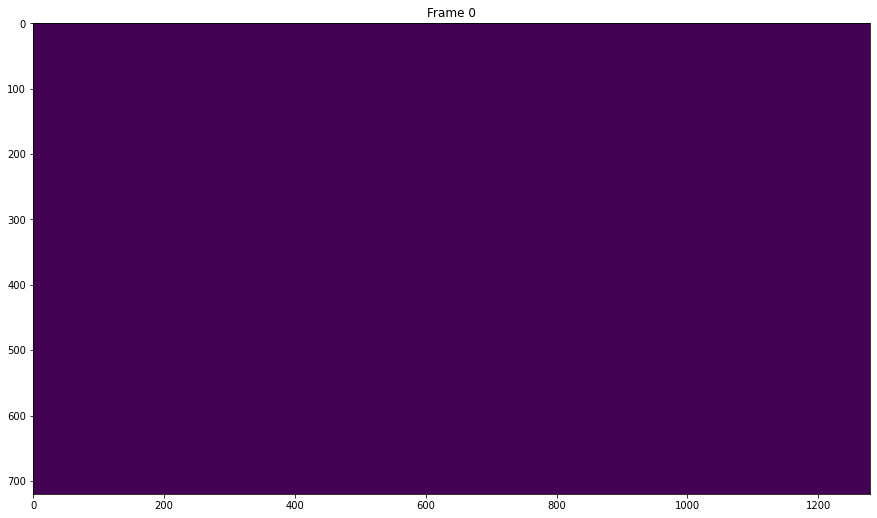

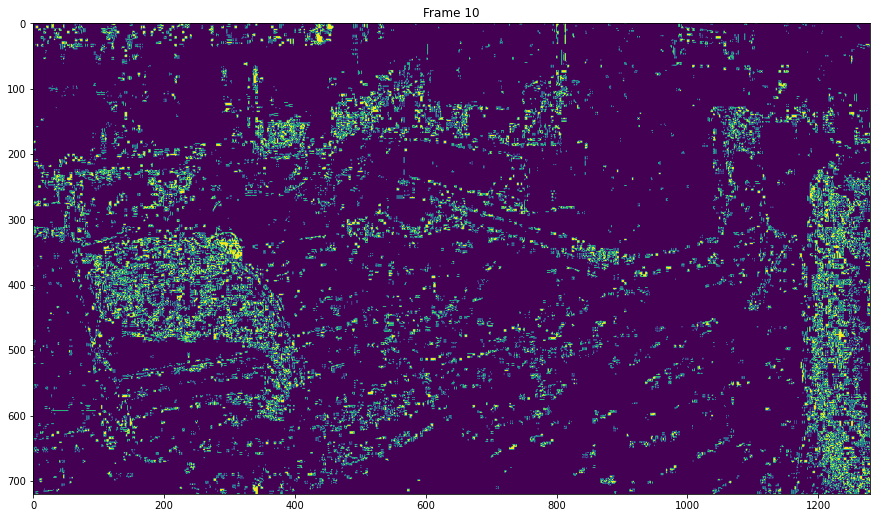

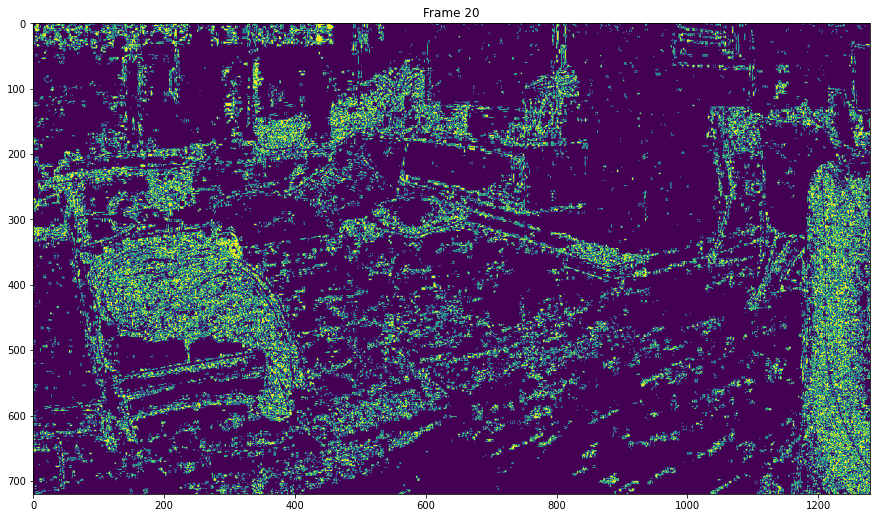

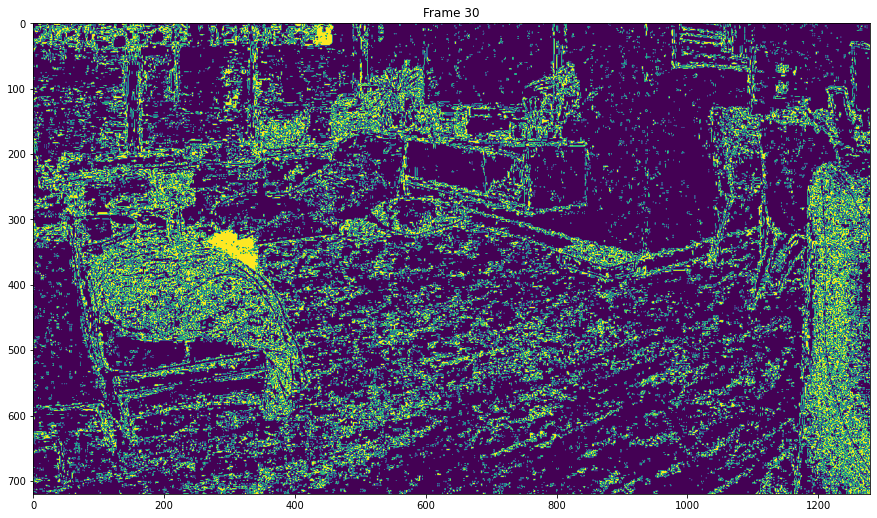

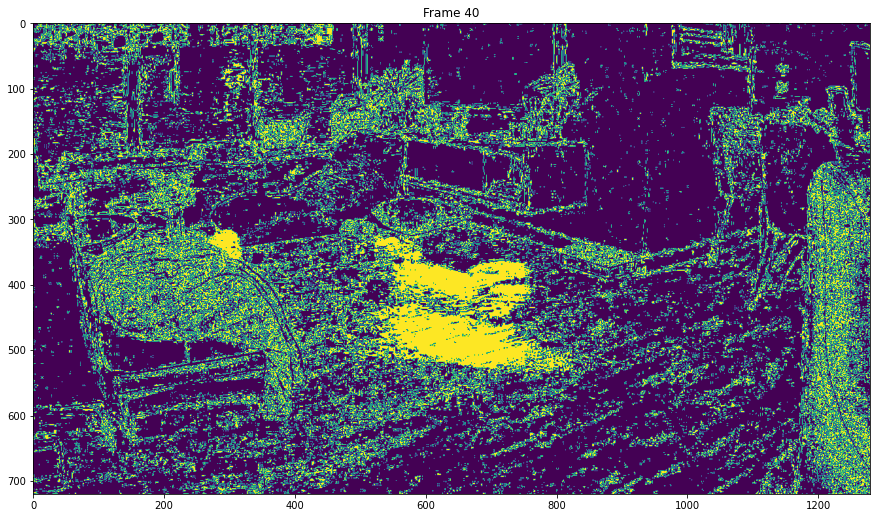

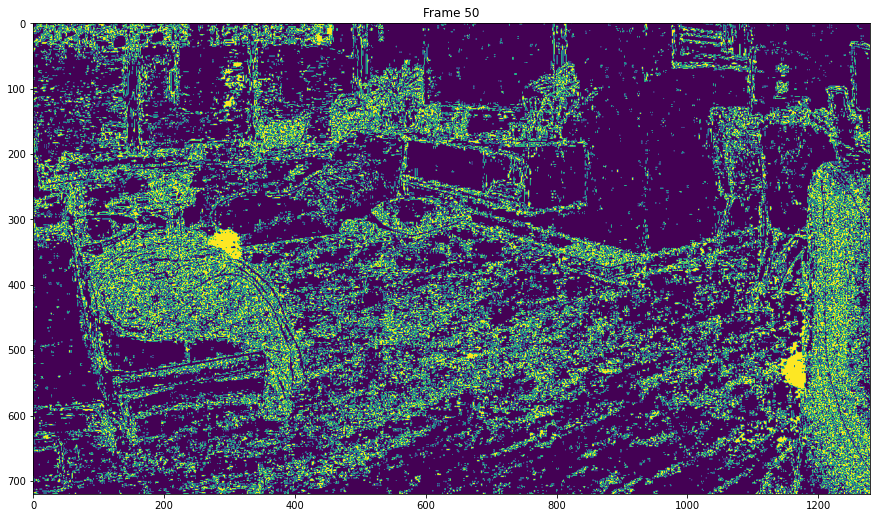

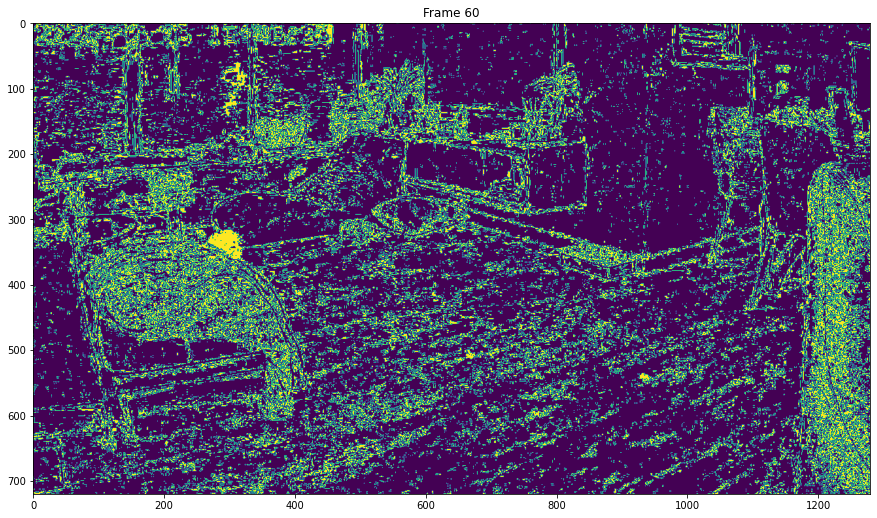

In [14]:
v_fg_mask, gmm_model = run_gmm(vid, k=k, t=t, alpha=alpha, learning_rate=learning_rate, k_warm_up=k_warm_up,
                        univariate=univariate, gmm_model=gmm_model, predict=predict)
play_video_by_images(v_fg_mask, frame_rate=10)

### Postprocessing - Improve foreground mask
Applying erosion and dilation function using the OpenCV library to remove noise and combine close enough points.

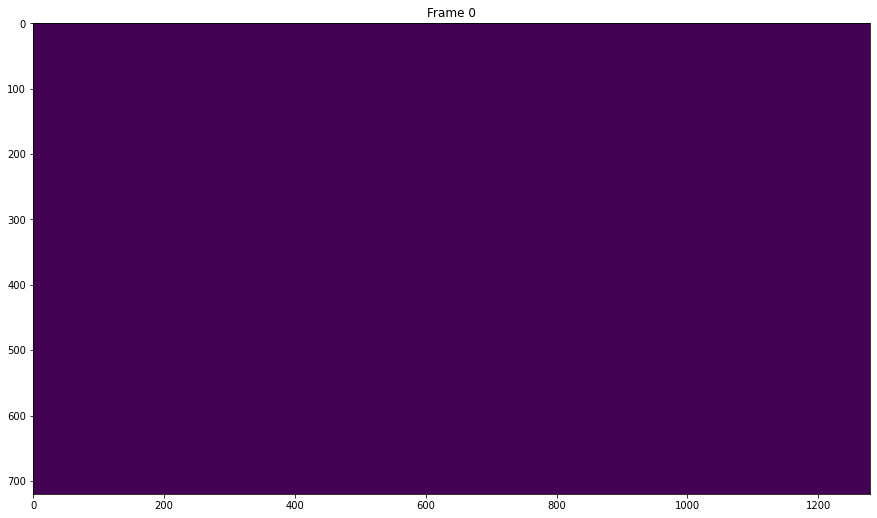

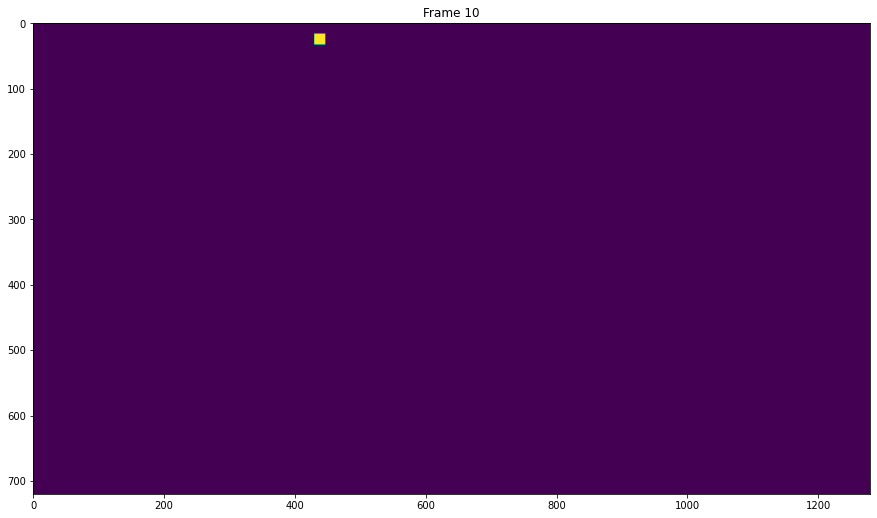

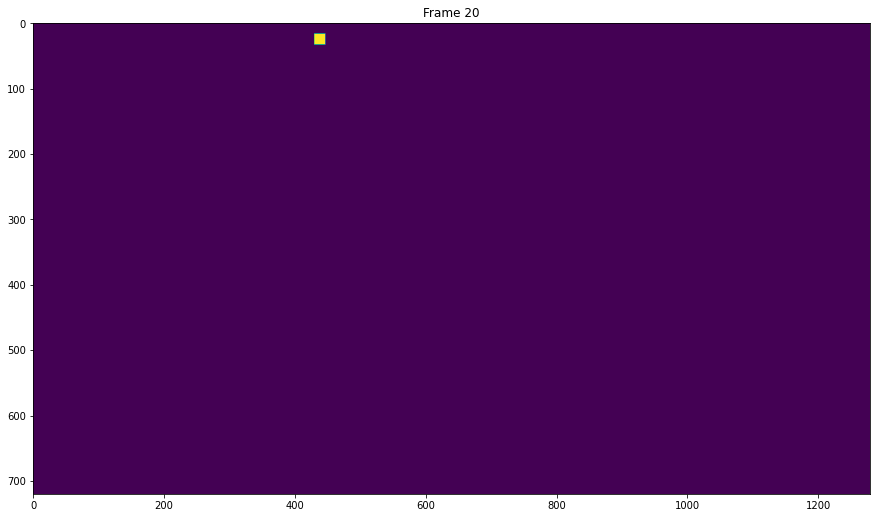

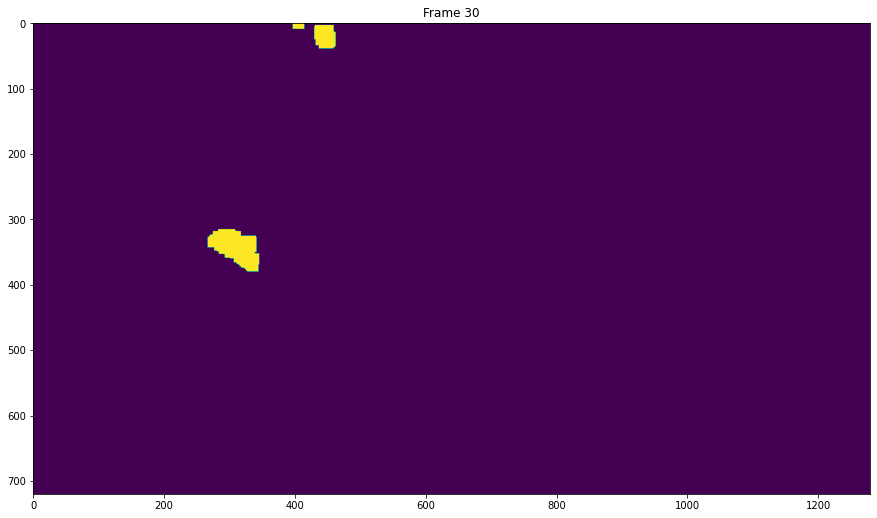

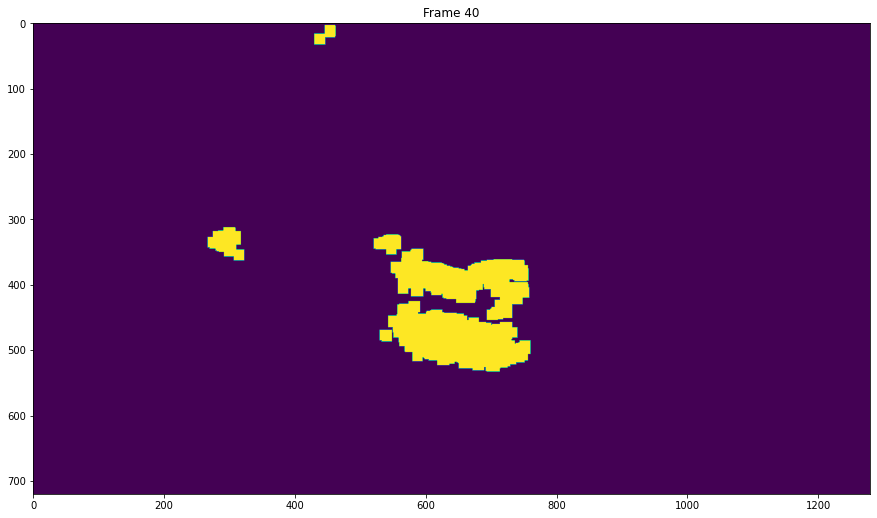

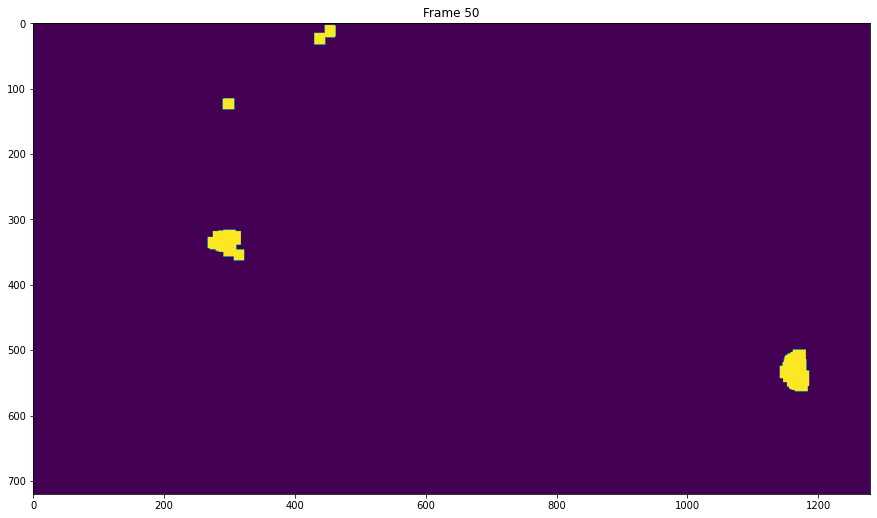

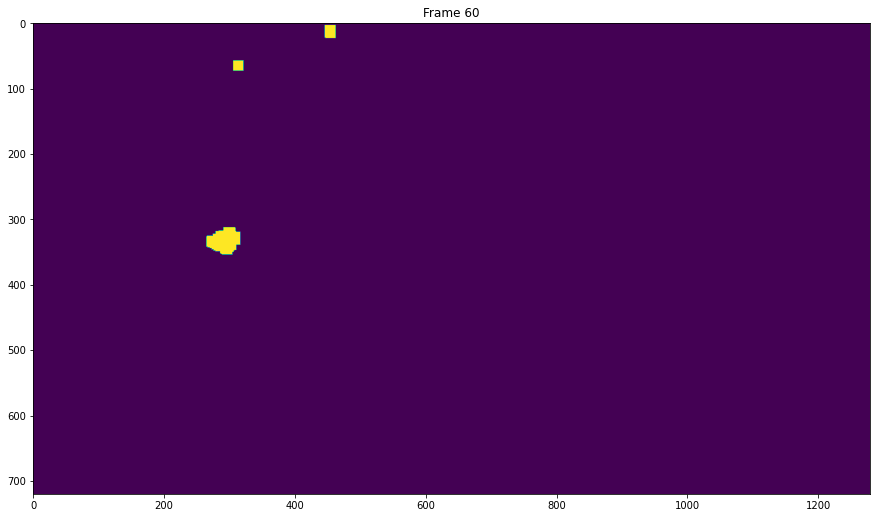

In [15]:
v_fg_mask_pp = improve_foreground(v_fg_mask)
play_video_by_images(v_fg_mask_pp, frame_rate=10)

### Find Contours
Iterate over the video and for each frame display rectangles framing the significant detected objects

In [17]:
frames_contours = find_contours(v_fg_mask_pp.copy())

## Object Classification 
For each frame in the video, the algorithm compares each contour information with the approved objects’ information from the preprocessing part. The information compared is the object’s RGB histograms and the size.

In [18]:
# Create the output directory
image_folder = path.join('data', 'object_classification')
if not path.isdir(image_folder):
    os.mkdir(image_folder)

In [19]:
# Setting counters for total approved and unapproved objects in the scene
approved_objects_total = 0
not_approved_objects_total = 0

### Classify if approved or not
Iterate over the frames and for each one decide if the objects approved or not.
If approved the object will have a blue frame, if not a red one.
Finally saving the classified frames images.

In [20]:
# Iterating over each frame in the video
for frame_index, detected_objects_location in frames_contours.items():
    frame = colored_vid[frame_index]
    num_of_objects = len(detected_objects_location)
    # get the information of the detected objects- RGB histogram and size.
    objects_info = get_detected_objects_info(frame, detected_objects_location, image_x_grid, image_y_grid, window_size)
    # Decide if the object is approved or not approved and add them to the approproiate list.
    approved_objects, not_approved_objects = match_with_approved_objects(num_of_objects, objects_info, approved_objects_info)
    # Increment counters.
    approved_objects_total += len(approved_objects)
    not_approved_objects_total += len(not_approved_objects)
    # Save the images with appropriate colord boxes wrapping them.
    save_images_with_boxes(frame, frame_index, approved_objects, not_approved_objects, detected_objects_location, out_dir = image_folder)

### Load the result video

In [21]:
# We will load the frames from the previous loop and concatenate them into a new video.
out_video_path = path.join(image_folder, 'video.mp4')
save_frames_video(image_folder, out_video_path)

In [22]:
Video(out_video_path, height=400, width=600)

# Test Dataset
We will execute the algorithm on 8 different videos - 4 should alarm and 4 should not.<br>
We calculate the measures on the results of these videos

In [23]:
predict = True
model_path = path.join('data', 'model', 'True.pickle')
videos_dir_path = path.join('data', 'videos', 'measures')
videos_list = [video_name for video_name in listdir(videos_dir_path) if video_name.endswith('mp4')]

In [24]:
### Load pretrained model 
with open(model_path, 'rb') as f:
    gmm_model = pickle.load(f)

In [25]:
def calculate_frames_contours(video_name, k=3, t=0.7, alpha=2.5, learning_rate=0.5, k_warm_up=1, univariate=univariate,
                                                model_path=model_path, predict=predict):
    
    print(f'Change detection start for video {video_name}')
    video_path = path.join('data', 'videos', 'measures', video_name)
    colored_vid = load_video(video_path=video_path, gray_scale=False)

    if univariate:
        vid = load_video(video_path=video_path, gray_scale=True)
    else:
        vid = colored_vid.copy()

    v_fg_mask, _ = run_gmm(vid, k=k, t=t, alpha=alpha, learning_rate=learning_rate, k_warm_up=k_warm_up,
                    univariate=univariate, gmm_model=gmm_model, predict=predict)
    v_fg_mask_pp = improve_foreground(v_fg_mask)
    return find_contours(v_fg_mask_pp), colored_vid

In [26]:
tp = []
tn = []
fp = []
fn = []
for video_name in videos_list:
    
    frames_contours, colored_vid = calculate_frames_contours(video_name, k=3, t=0.7, alpha=2.5, learning_rate=0.5, k_warm_up=1, univariate=univariate,
                                                model_path=model_path, predict=predict)
    approved_objects_total = 0
    not_approved_objects_total = 0
    for frame_index, detected_objects_location in frames_contours.items():
        frame = colored_vid[frame_index]
        num_of_objects = len(detected_objects_location)
        objects_info = get_detected_objects_info(frame, detected_objects_location, image_x_grid, image_y_grid, window_size)
        approved_objects, not_approved_objects = match_with_approved_objects(num_of_objects, objects_info, approved_objects_info)
        approved_objects_total += len(approved_objects)
        not_approved_objects_total += len(not_approved_objects)
    
    # Setting the label to '0' if the video should be approved and to '1' if not.
    label_ = 0 if 'not_alarm' in video_name else 1
    # Setting the threshold to 0.35 to determine if the video is approved or not.
    prediction_ = 0 if approved_objects_total / (approved_objects_total+not_approved_objects_total) > 0.35 else 1

    if prediction_ == 1: print(f"{video_name} contains moving unauthorized objects")
    if prediction_ == 0: print(f"{video_name} contains moving authorized objects")

    if (label_ == 1) and (prediction_ == 1):
        tp.append(video_name)
    elif (label_ == 0) and (prediction_ == 0):
        tn.append(video_name)
    elif (label_ == 0) and (prediction_ == 1):
        fp.append(video_name)
    elif (label_ == 1) and (prediction_ == 0):
        fn.append(video_name)

    print(f'Change detection done for video {video_name}')

print(f'TP: {len(tp)}')
print(f'TN: {len(tn)}')
print(f'FN: {len(fn)}')
print(f'FP: {len(fp)}')

accuracy = (len(tp) + len(tn)) / len(videos_list)
recall = len(tp) / (len(tp) + len(fn))
precision = len(tp) / (len(tp) + len(fp))

Change detection start for video not_alarm4.mp4


  0%|          | 0/18 [00:00<?, ?it/s]

Start iterating over frames to detect foreground


100%|██████████| 18/18 [03:15<00:00, 10.87s/it]


not_alarm4.mp4 contains moving unauthorized objects
Change detection done for video not_alarm4.mp4
Change detection start for video not_alarm2.mp4


  0%|          | 0/21 [00:00<?, ?it/s]

Start iterating over frames to detect foreground


  0%|          | 0/13 [00:00<?, ?it/s]

not_alarm2.mp4 contains moving authorized objects
Change detection done for video not_alarm2.mp4
Change detection start for video not_alarm3.mp4
Start iterating over frames to detect foreground


100%|██████████| 13/13 [01:54<00:00,  8.81s/it]


not_alarm3.mp4 contains moving authorized objects
Change detection done for video not_alarm3.mp4
Change detection start for video not_alarm1.mp4


  0%|          | 0/16 [00:00<?, ?it/s]

Start iterating over frames to detect foreground


100%|██████████| 16/16 [02:37<00:00,  9.83s/it]


not_alarm1.mp4 contains moving unauthorized objects
Change detection done for video not_alarm1.mp4
Change detection start for video alarm1.mp4


  0%|          | 0/25 [00:00<?, ?it/s]

Start iterating over frames to detect foreground


100%|██████████| 25/25 [04:19<00:00, 10.38s/it]


alarm1.mp4 contains moving unauthorized objects
Change detection done for video alarm1.mp4
Change detection start for video alarm3.mp4


  0%|          | 0/201 [00:00<?, ?it/s]

Start iterating over frames to detect foreground


100%|██████████| 201/201 [35:24<00:00, 10.57s/it]


alarm3.mp4 contains moving unauthorized objects
Change detection done for video alarm3.mp4
Change detection start for video alarm2.mp4


  0%|          | 0/31 [00:00<?, ?it/s]

Start iterating over frames to detect foreground


100%|██████████| 31/31 [05:39<00:00, 10.96s/it]


alarm2.mp4 contains moving unauthorized objects
Change detection done for video alarm2.mp4
Change detection start for video alarm4.mp4


  0%|          | 0/225 [00:00<?, ?it/s]

Start iterating over frames to detect foreground


100%|██████████| 225/225 [27:33<00:00,  7.35s/it]


alarm4.mp4 contains moving unauthorized objects
Change detection done for video alarm4.mp4
TP: 4
TN: 2
FN: 0
FP: 2


In [27]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.6666666666666666
Recall: 1.0
Accuracy: 0.75


## Plotting Confusion Matrix

[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative')]

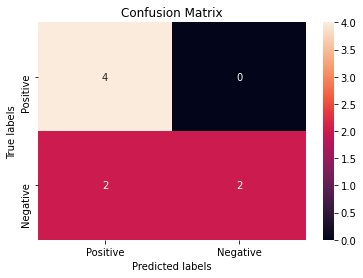

In [28]:
conf_matrix = np.array([[len(tp), len(fn)],[len(fp), len(tn)]])


ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative'])